In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os


In [3]:
print(os.listdir("/gdrive/My Drive/Kidney Cancer"))

['Tumor', 'Normal']


In [4]:
DATADIR = "/gdrive/My Drive/Kidney Cancer"

CATEGORIES = ["Normal","Tumor"]

In [5]:
IMG_SIZE = 100

In [6]:
all_data = []

def create_all_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                all_data.append([new_array, class_num])
            except Exception as e:
                pass

create_all_data()


In [7]:
print("Toplam Görüntü Sayısı: ", len(all_data))

Toplam Görüntü Sayısı:  10000


In [8]:
X = []
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)

In [9]:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [10]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [11]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(7200, 100, 100)
(2000, 100, 100)
(800, 100, 100)
(7200,)
(2000,)
(800,)


In [12]:
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

x_train = np.repeat(x_train, 3, axis=-1)
x_val = np.repeat(x_val, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

In [13]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

In [14]:
import tensorflow as tf

train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=2)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=2)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [15]:
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

In [16]:
res = tf.keras.applications.ResNet50V2(
    input_shape=(100, 100, 3),
    include_top = False
)

94668760/94668760 [==============================] - 0s 0us/step


In [17]:
res_model = Sequential()
res_model.add(res)
res_model.add(Dropout(0.25))
res_model.add(MaxPooling2D())
res_model.add(Flatten())
res_model.add(Dense(256, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(2, activation='softmax'))

In [18]:
res_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
history = res_model.fit(x_train, train_yCl,
                        batch_size=120,
                        epochs=10,
                        validation_data=(x_val, valid_yCl))

Epoch 1/10
60/60 [==============================] - 1589s 26s/step - loss: 0.1468 - accuracy: 0.9542 - val_loss: 2.1519 - val_accuracy: 0.6350
Epoch 2/10
60/60 [==============================] - 1511s 25s/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 3.9930 - val_accuracy: 0.7262
Epoch 3/10
60/60 [==============================] - 1523s 25s/step - loss: 0.0112 - accuracy: 0.9962 - val_loss: 0.0380 - val_accuracy: 0.9875
Epoch 4/10
60/60 [==============================] - 1541s 26s/step - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.9400 - val_accuracy: 0.8850
Epoch 5/10
60/60 [==============================] - 1551s 26s/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 0.8086 - val_accuracy: 0.8512
Epoch 6/10
60/60 [==============================] - 1544s 26s/step - loss: 0.0135 - accuracy: 0.9964 - val_loss: 0.2352 - val_accuracy: 0.9337
Epoch 7/10
60/60 [==============================] - 1541s 26s/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.0030 - val_accuracy: 0.9975

In [20]:
score_valid = res_model.evaluate(x_val, valid_yCl)
print("Validation Accuracy: ", score_valid[1])

score_test = res_model.evaluate(x_test, test_yCl)
print("Test Accuracy: ", score_test[1])

score_train = res_model.evaluate(x_train, train_yCl)
print("Train Accuracy: ", score_train[1])

25/25 [==============================] - 59s 2s/step - loss: 8.8543e-05 - accuracy: 1.0000
Validation Accuracy:  1.0
63/63 [==============================] - 88s 1s/step - loss: 0.0033 - accuracy: 0.9990
Test Accuracy:  0.9990000128746033
225/225 [==============================] - 294s 1s/step - loss: 1.0471e-04 - accuracy: 1.0000
Train Accuracy:  1.0


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Test verisi üzerinde tahminlerde bulunun
y_pred_probs = res_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Gerçek sınıfları alın
y_true_classes = np.argmax(test_yCl, axis=1)

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"F1-Score: {f1}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)


63/63 [==============================] - 88s 1s/step
Accuracy: 0.999
Precision: 0.999
Recall: 0.999
F1-Score: 0.999
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1012
           1       1.00      1.00      1.00       988

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
[[1011    1]
 [   1  987]]


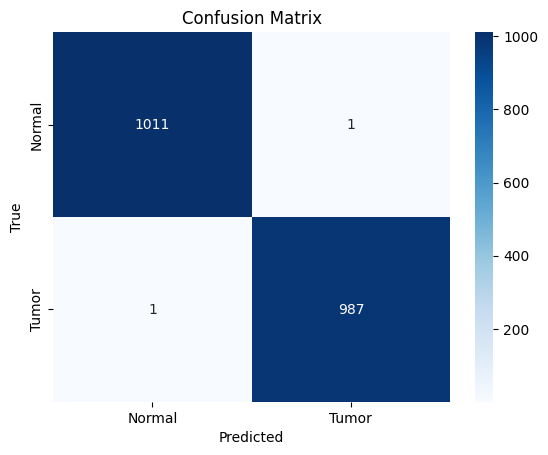

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
